# Anomaly Detection in Social Networks

Code for the project found on [my website](www.pwills.com/portfolio/social-networks).

In [1]:
import netcomp as nc
import networkx as nx

plt.style.use(['classic','ggplot']) # make those plots look nice

We're looking at the [primary school temporal network dataset](http://www.sociopatterns.org/datasets/primary-school-temporal-network-data/).

# Get data from web

In [2]:
%%bash
cd data
curl -O http://www.sociopatterns.org/wp-content/uploads/2015/09/primaryschool.csv.gz
gunzip primaryschool.csv.gz

# grab metadata too

bash: line 1: cd: data: No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  464k  100  464k    0     0   192k      0  0:00:02  0:00:02 --:--:--  193k


# Load in data

We have a bunch of time-stamped edges in a csv. We need to turn these into a sequence of graphs so that we can look at the resistance distance between timesteps. Let's see how this does.

In [2]:
full_data = pd.read_csv('primaryschool.csv',sep='\t',header=None)
full_data.columns = ['Time','i','j','Class i','Class j']

data = full_data[full_data['Time'] <= 62300] # select only the first day

In [3]:
n_bins = 150
graphs = []
amats = []
amats_clean = []
bins = pd.cut(data['Time'],bins=n_bins,labels=np.arange(n_bins))

students = set(data['i'])|set(data['j'])

for group,df in data.groupby(bins):
    G = nx.Graph()
    G.add_nodes_from(students)
    G.add_edges_from(zip(df['i'],df['j']))
    graphs.append(G)
    amats.append(nx.adjacency_matrix(G))

# Calculate distance

Calculate the resistance distance between each timestep.

In [5]:
%%time

dists = [nc.resistance_distance(A,A_old,renormalized=True)
         for A_old,A in zip(amats[:-1],amats[1:])]

CPU times: user 48.3 s, sys: 589 ms, total: 48.9 s
Wall time: 51.2 s


## Make Labels for Ground-Truth Anomalies

We know when things change throughout the school day. Let's label our plot accordingly, to lead the eye.

In [6]:
# Assume start at 9 AM, end at 5 PM, subdivide time bins accordingly
times = [pd.to_datetime('10/1/2009 {}:{:.02f}'.format(int(time//1),60*(time%1))) 
         for time in np.linspace(9,17,num=n_bins)]

# our anomalies
significant_times = [pd.to_datetime('10/1/2009 ' + time_str) for time_str in 
                     ['10:30','11:00','12:00','13:00','14:00','15:30','16:00']]
time_labels = ['Morning Recess Begins',
               'Morning Recess Ends','First Lunch Begins','Second Lunch Begins',
               'Second Lunch Ends','Afternoon Recess Begins','Afternoon Recess Ends']

# we'll only mark the start of each bin, so we don't need the last one
times = times[:-1]
# things freak out towards the end of the day, as the graph dissolves
cutoff = -8

In [7]:
xtick_times = [pd.to_datetime('10/1/2009 {}:{:.02f}'.format(int(time//1),60*(time%1))) 
               for time in np.linspace(9,16,num=8)]
xtick_labels = ['{} AM'.format(i) for i in range(9,13)] + ['{} PM'.format(i) for i in range(1,5)]

# iterable of colors to use for anomaly indicators
color_list = ['#1f77b4','#ff7f0e','#2ca02c','#d6272b','#9467bd','#8c564b','#e377c2']
# these are matplotlib.patch.Patch properties. see https://matplotlib.org/users/recipes.html
props = [dict(boxstyle='round',color=color) for color in color_list]

# Make a Pretty Plot

We'll make it nice, so that we can publish it online.

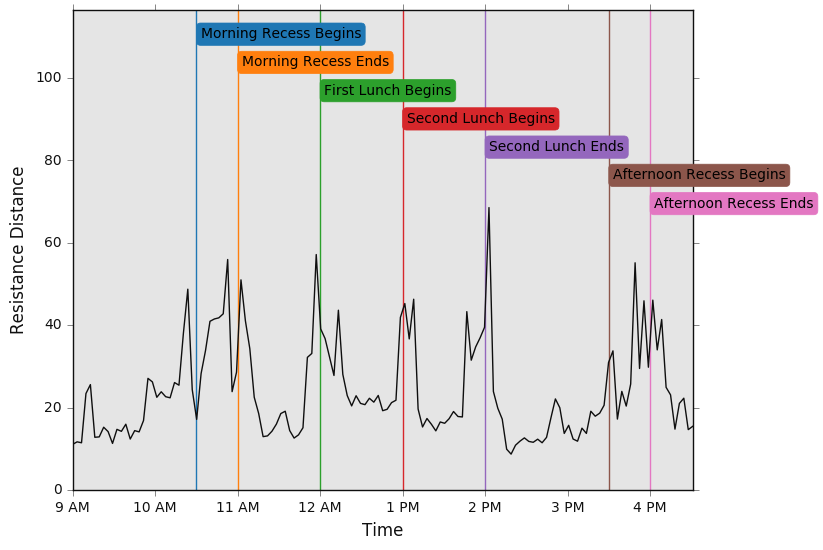

In [8]:
data_max = max(dists[:cutoff])

# Make locations for text
step = 0.1*data_max
text_heights = [data_max+step*i for i,_ in enumerate(significant_times)]
text_heights = text_heights[::-1]
text_times = [time+pd.Timedelta(minutes=3) for time in significant_times]
top = text_heights[0] + step

fig = plt.figure()

# make horizontal & vertical lines
[plt.axvline(dtime,color=color) for dtime,color in zip(significant_times,color_list)]
[plt.text(x,y,label,bbox=prop) for x,y,label,prop in 
 zip(text_times,text_heights,time_labels,props)]

black = '#0f0f0f'

# plot curves
plt.plot(times[:cutoff],dists[:cutoff],color=black);

# axes labels & title
plt.ylim([0,top]);
plt.yticks([0,20,40,60,80,100],color=black)
plt.xticks(xtick_times,xtick_labels,color=black);
plt.xlabel('Time',color=black);
plt.ylabel('Resistance Distance',color=black);

ax = fig.axes[0]
ax.grid();
for _,spine in ax.spines.items():
    plt.setp(spine, color=black)
    
    
fig.savefig('social.png',transparent=True,bbox_inches='tight')